In [1]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os
import time

import snapshot_obj
import dataset_compute
import curve_fit

import importlib

In [3]:
importlib.reload(snapshot_obj)
importlib.reload(dataset_compute)
importlib.reload(curve_fit)

<module 'curve_fit' from '/home/kassiili/Curvaton_Simulations/analysis/curve_fit.py'>

# Subhalo stellar ages

## Construct data dictionary

Add entries for each simulation, and specify M31 and MW galaxies:

In [5]:
snap_id = 127
sim_ids = ["V1_LR_fix", "V1_LR_curvaton_p082_fix", "V1_LR_curvaton_p084_fix"]
names = ["LCDM", "p082", "p084"]
paths = ["", "/media/kassiili/USBFREE/LG_simulations", 
        "/media/kassiili/USBFREE/LG_simulations"]

# Define M31 and MW in each simulation:
m31 = [(1,0), (1,0), (1,0)]
mw = [(2,0), (1,1), (1,1)]

data = {}
for name, sim_id, sim_path, m31_ns, mw_ns in zip(names, sim_ids, paths, m31, mw):
    data[name] = {"snapshot": snapshot_obj.Snapshot(sim_id, snap_id, name=name,
                                                    sim_path=sim_path),
                  "M31_identifier": m31_ns,
                  "MW_identifier": mw_ns}

Choose how to distinguish between satellite and isolated galaxies:

In [6]:
distinction = "by_gn"

In [7]:
for name, sim_data in data.items():
    snap = sim_data["snapshot"]
    sf_times = snap.get_subhalos("InitialMassWeightedBirthZ")
           
    # Split into satellites:
    if distinction == "by_r":
        masks_sat, mask_isol = dataset_compute.split_satellites_by_distance(
            snap, sim_data["M31_identifier"], sim_data["MW_identifier"])
    elif distinction == "by_gn":
        masks_sat, mask_isol = dataset_compute.split_satellites_by_group_number(
            snap, sim_data["M31_identifier"], sim_data["MW_identifier"])
        
    print(name, np.sum(np.logical_or.reduce(masks_sat)))
    mask_lum, mask_dark = dataset_compute.split_luminous(snap)
    mask_nonzero_vmax = dataset_compute.prune_vmax(snap)
    
    # Add separate datasets for each subhalo to the data dictionary:
    data[name] = \
    {"StellarFormationTime": \
     {"satellites": sf_times[np.logical_and.reduce(
        [np.logical_or.reduce(masks_sat), mask_lum, mask_nonzero_vmax]
    )],
      "isolated": sf_times[np.logical_and.reduce(
          [mask_isol, mask_lum, mask_nonzero_vmax]
      )]
     }
    }


LCDM 112
p082 57
p084 11


## Plot

In [8]:
cols = ["grey", "pink", "lightblue"]

LCDM 32
p082 30
p084 4
LCDM 70
p082 54
p084 18


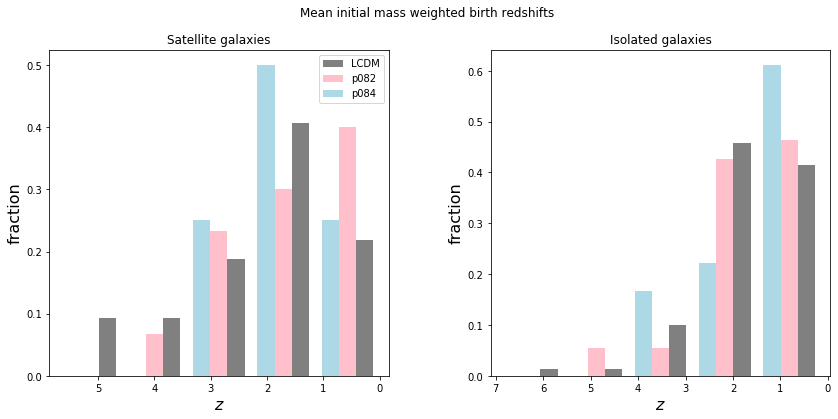

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
plt.subplots_adjust(wspace=0.3)

fig.suptitle("Mean initial mass weighted birth redshifts")

# Set axis:
for ax in axes:  
    ax.set_xlabel('$z$', fontsize=16)
    ax.set_ylabel('fraction', fontsize=16)

axes[0].set_title('Satellite galaxies')
axes[1].set_title('Isolated galaxies')

axes[0].invert_xaxis()
axes[1].invert_xaxis()

# Make satellite histograms and plot:
sf_times = []
weights = []
for i, (name, sim_data) in enumerate(data.items()):
    sf_times.append(sim_data["StellarFormationTime"]["satellites"])
    n_stars = sf_times[i].size
    print(name, n_stars)
    weights.append(np.ones(n_stars)/n_stars)

bins = np.linspace(0, 1, 20)
_ = axes[0].hist(sf_times, 5, weights=weights, color=cols, label=data.keys())

# Make isolated galaxy histograms and plot:
sf_times = []
weights = []
for i, (name, sim_data) in enumerate(data.items()):
    sf_times.append(sim_data["StellarFormationTime"]["isolated"])
    n_stars = sf_times[i].size
    print(name, n_stars)
    weights.append(np.ones(n_stars)/n_stars)

bins = np.linspace(0, 1, 20)
_ = axes[1].hist(sf_times, 5, weights=weights, color=cols)

axes[0].legend()